# Voxel VAE-GAN Training

This notebook is designed to provide a wholistic vae-gan training experience. You can adjust the model and training parameters through the sacred configuration file, you can view training progress in tensorboard, and you can (wip) create reconstructions with the saved models!

## Setup

In [1]:
import env
from train_vaegan import train_vaegan

# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2

## Prepare Sacred Experiment

In [2]:
from sacred.observers import FileStorageObserver
from sacred import Experiment

ex = Experiment(name='voxel_vaegan_notebook', interactive=True)
ex.observers.append(FileStorageObserver.create('experiments_vaegan'))

@ex.main
def run_experiment(cfg):
    train_vaegan(cfg)

import datetime
last_model_dir = None

## Prepare Model Config

The model dir is generated with a timestamp. This keeps you from overwriting past results and keeps results separate to avoid confusing tensorboard.

But be warned! These model dirs can take up space, so you might need to periodically go back and delete ones you do not care about.

Also, if you ever train a model that you would really like to keep, I recommend moving it to a new directory with a special name like "best_model_ever".

In [36]:
def make_cfg():
    MODEL_DIR = 'voxel_vaegan1/{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    print(MODEL_DIR)

    cfg = {
        'cfg': {
            "dataset": {
                "index": "../data/processed/thingi10k_index.csv",
                #"tag": "animal",
                "pctile": 1.0,
                "splits": {
                    "train": .8,
                    "dev": .1,
                    "test": .1
                }
            },
            "generator": {
                "verbose": False,
                "pad": True
            }, 
            "model": {
                "ckpt_dir": MODEL_DIR,
                "voxels_dim": 32,
                "batch_size": 32,
                "example_stl_id": 126660,
                "voxel_prob_threshold": 0.065,
                "enc_lr": 0.0001,
                "dec_lr": 0.0001,
                "dis_lr": 0.0001,
                "keep_prob": 1.0,
                "kl_div_loss_weight": 1,
                "recon_loss_weight": 10,            
                "latent_dim": 100,
                "verbose": True,
                "debug": True,
                "epochs": 50,
                "input_repeats": 1,
                "display_step": 10,
                "dev_step": 1,
                "save_step": 10,
                'launch_tensorboard': True,
                'tb_dir': 'tb',
                'no_gan': True
            }
        }
    }
    
    return cfg

## Tensorboard Prep

We launch tensorboard with a call to the python subprocess module. Sometimes, that process does not die with the rest of the experiment and lingers on as a system process. This becomes a problem when we try to initialize tensorboard for the next experiment because they cannot share the same port!

The function below is designed to solve this problem. It uses the linux pgrep utility to search for existing tensorboard processes and kill them. Note that this probably won't work on Windows.

In [37]:
from utils import kill_tensorboard

kill_tensorboard()

['pgrep', 'tensorboard'] yielded -> b'7529\n9744\n'
killed b'7529'!
killed b'9744'!


## Training

We start with a check that we are not attempting to overwrite the last MODEL_DIR. If you are blocked by the assert, re-execute the cfg code above to generate a new MODEL_DIR. This will allow you to move ahead with training.

The sacred experiment will save away a copy of your experiment settings in an experiments directory. This can be accessed later in case we need to retrieve a prime config.

If tensorboard is enabled, tune in at localhost:6006 or your_ip:6006
   

In [38]:
cfg = make_cfg()
MODEL_DIR = cfg.get('cfg').get('model').get('ckpt_dir')
kill_tensorboard()

voxel_vaegan1/2019-03-12_06-41-30
['pgrep', 'tensorboard'] yielded -> b'7529\n9744\n'
killed b'7529'!
killed b'9744'!


In [ ]:
if last_model_dir == MODEL_DIR:
    print('dont overwrite!')
    assert False
else:
    last_model_dir = MODEL_DIR

ex.run(config_updates=cfg)

WARNING - root - Added new config entry: "cfg.dataset.index"
WARNING - root - Added new config entry: "cfg.dataset.pctile"
WARNING - root - Added new config entry: "cfg.dataset.splits.dev"
WARNING - root - Added new config entry: "cfg.dataset.splits.test"
WARNING - root - Added new config entry: "cfg.dataset.splits.train"
WARNING - root - Added new config entry: "cfg.generator.pad"
WARNING - root - Added new config entry: "cfg.generator.verbose"
WARNING - root - Added new config entry: "cfg.model.batch_size"
WARNING - root - Added new config entry: "cfg.model.ckpt_dir"
WARNING - root - Added new config entry: "cfg.model.debug"
WARNING - root - Added new config entry: "cfg.model.dec_lr"
WARNING - root - Added new config entry: "cfg.model.dev_step"
WARNING - root - Added new config entry: "cfg.model.dis_lr"
WARNING - root - Added new config entry: "cfg.model.display_step"
WARNING - root - Added new config entry: "cfg.model.enc_lr"
WARNING - root - Added new config entry: "cfg.model.epoch

Logging to /home/jcworkma/jack/3d-form/src/logs/2019-03-12_06-41__root.log
Starting train_vaegan main
Using thingi10k with index ../data/processed/thingi10k_index.csv and pctile 1.0
Thingi10k n_input=9945
Splitting Datasets
Train Length: 7956
Dev Length: 996
Test Length: 993
Num input = 9945
Num batches per epoch = 310.78
Initializing VoxelVaegan
encoder/enc_conv1/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
decoder/dec_dense1/BiasAdd:0: (?, 343)
decoder/Elu:0: (?, 343)
decoder/reshape_z:0: (?, 7, 7, 7, 1)
decoder/batch_normalization_1/batchnorm/add_1:0: (?, 7, 7, 7, 

/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


['tensorboard', '--logdir', '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_06-41-30/tb']
Epoch: 0, Elapsed Time: 0.01
Epoch: 0, Batch: 0, Elapsed time: 0.05 mins
Enc Loss = 1.18, KL Divergence = 20.39, Reconstruction Loss = 4410.80, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 0.08 mins
Epoch: 0, Batch: 1, Elapsed time: 0.10 mins
Enc Loss = 1.62, KL Divergence = 28.42, Reconstruction Loss = 1742.54, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 0.11 mins
Epoch: 0, Batch: 2, Elapsed time: 0.13 mins
Enc Loss = 1.09, KL Divergence = 13.31, Reconstruction Loss = 1884.52, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 0.14 mins
Epoch: 0, Batch: 3, Elapsed time: 0.15 mins
Enc Loss = 1.10, KL Divergence = 9.84, Reconstruction Loss = 2045.55, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 0.17 mins
Epoch: 0, Batch: 4, Elapsed time: 0.17 mins
Enc Loss = 0.82, KL Divergence = 6.33, Reconstruction Loss = 1626.58, -dis_Loss = 999.00, dec_Loss = -

Exception in thread Thread-55:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/sacred/utils.py", line 469, in run
    self.func()
  File "/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/sacred/run.py", line 327, in _emit_heartbeat
    self._get_captured_output()
  File "/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/sacred/run.py", line 248, in _get_captured_output
    text = self._output_file.get()
  File "/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/sacred/stdout_capturing.py", line 69, in get
    value = self.buffer.read()
  File "/usr/lib/python3.5/tempfile.py", line 622, in func_wrapper
    return func(*args, **kwargs)
  File "/usr/lib/python3.5/codecs.py", line 321, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec ca

Epoch: 0, Batch: 19, Elapsed time: 0.78 mins
Enc Loss = 0.65, KL Divergence = 2.64, Reconstruction Loss = 1257.86, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 0.79 mins
Epoch: 0, Batch: 20, Elapsed time: 0.80 mins
Enc Loss = 0.75, KL Divergence = 4.58, Reconstruction Loss = 1918.23, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 0.82 mins
conversion timed out for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/518039.stl
Epoch: 0, Batch: 21, Elapsed time: 1.16 mins
Enc Loss = 0.74, KL Divergence = 3.13, Reconstruction Loss = 1881.00, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 1.17 mins
Epoch: 0, Batch: 22, Elapsed time: 1.33 mins
Enc Loss = 1.07, KL Divergence = 4.66, Reconstruction Loss = 2382.75, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 1.34 mins
Epoch: 0, Batch: 23, Elapsed time: 1.34 mins
Enc Loss = 1.03, KL Divergence = 3.83, Reconstruction Loss = 2966.88, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 1.36 mins

Epoch: 0, Batch: 64, Elapsed time: 3.45 mins
Enc Loss = 0.52, KL Divergence = 1.64, Reconstruction Loss = 1228.94, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 3.46 mins
Epoch: 0, Batch: 65, Elapsed time: 3.48 mins
Enc Loss = 0.52, KL Divergence = 1.50, Reconstruction Loss = 1293.32, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 3.50 mins
Epoch: 0, Batch: 66, Elapsed time: 3.50 mins
Enc Loss = 0.61, KL Divergence = 1.77, Reconstruction Loss = 1752.97, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 3.52 mins
Epoch: 0, Batch: 67, Elapsed time: 3.53 mins
Enc Loss = 0.55, KL Divergence = 1.68, Reconstruction Loss = 1470.52, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 3.55 mins
Epoch: 0, Batch: 68, Elapsed time: 3.57 mins
Enc Loss = 0.45, KL Divergence = 1.22, Reconstruction Loss = 1108.68, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 3.58 mins
Epoch: 0, Batch: 69, Elapsed time: 3.62 mins
Enc Loss = 0.55, KL Divergence = 3.75, Reconstruction Loss =

Epoch: 0, Batch: 109, Elapsed time: 5.88 mins
Enc Loss = 0.41, KL Divergence = 0.68, Reconstruction Loss = 1033.03, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 5.90 mins
Epoch: 0, Batch: 110, Elapsed time: 5.92 mins
Enc Loss = 0.44, KL Divergence = 0.77, Reconstruction Loss = 1139.09, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 5.94 mins
Epoch: 0, Batch: 111, Elapsed time: 5.95 mins
Enc Loss = 0.60, KL Divergence = 1.34, Reconstruction Loss = 1636.68, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 5.96 mins
Epoch: 0, Batch: 112, Elapsed time: 6.01 mins
Enc Loss = 0.46, KL Divergence = 1.76, Reconstruction Loss = 2345.68, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 6.03 mins
Epoch: 0, Batch: 113, Elapsed time: 6.07 mins
Enc Loss = 0.52, KL Divergence = 0.97, Reconstruction Loss = 1180.32, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 6.08 mins
Epoch: 0, Batch: 114, Elapsed time: 6.10 mins
Enc Loss = 0.55, KL Divergence = 0.92, Reconstruction 

Epoch: 0, Batch: 155, Elapsed time: 7.71 mins
Enc Loss = 0.47, KL Divergence = 0.74, Reconstruction Loss = 1365.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 7.73 mins
Epoch: 0, Batch: 156, Elapsed time: 7.75 mins
Enc Loss = 0.44, KL Divergence = 0.52, Reconstruction Loss = 1121.93, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 7.77 mins
Epoch: 0, Batch: 157, Elapsed time: 7.82 mins
Enc Loss = 0.43, KL Divergence = 1.75, Reconstruction Loss = 3459.17, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 7.86 mins
Epoch: 0, Batch: 158, Elapsed time: 7.87 mins
Enc Loss = 0.45, KL Divergence = 0.76, Reconstruction Loss = 1249.70, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 7.89 mins
Epoch: 0, Batch: 159, Elapsed time: 7.94 mins
Enc Loss = 0.49, KL Divergence = 1.42, Reconstruction Loss = 2498.93, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 7.97 mins
Epoch: 0, Batch: 160, Elapsed time: 7.99 mins
Enc Loss = 0.54, KL Divergence = 0.68, Reconstruction 

Epoch: 0, Batch: 201, Elapsed time: 9.48 mins
Enc Loss = 0.50, KL Divergence = 0.54, Reconstruction Loss = 1427.43, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 9.50 mins
Epoch: 0, Batch: 202, Elapsed time: 9.52 mins
Enc Loss = 0.47, KL Divergence = 0.63, Reconstruction Loss = 1246.49, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 9.53 mins
Epoch: 0, Batch: 203, Elapsed time: 9.78 mins
Enc Loss = 0.43, KL Divergence = 0.51, Reconstruction Loss = 1173.35, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 9.80 mins
Epoch: 0, Batch: 204, Elapsed time: 9.81 mins
Enc Loss = 0.43, KL Divergence = 0.67, Reconstruction Loss = 1087.67, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 9.83 mins
Epoch: 0, Batch: 205, Elapsed time: 9.84 mins
Enc Loss = 0.45, KL Divergence = 0.50, Reconstruction Loss = 1202.92, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 9.86 mins
Epoch: 0, Batch: 206, Elapsed time: 9.86 mins
Enc Loss = 0.48, KL Divergence = 0.71, Reconstruction 

Epoch: 1, Batch: 10, Elapsed time: 11.88 mins
Enc Loss = 0.62, KL Divergence = 0.66, Reconstruction Loss = 1512.16, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 11.90 mins
Epoch: 1, Batch: 11, Elapsed time: 11.90 mins
Enc Loss = 0.45, KL Divergence = 0.57, Reconstruction Loss = 1366.03, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 11.92 mins
Epoch: 1, Batch: 12, Elapsed time: 11.99 mins
Enc Loss = 0.52, KL Divergence = 1.47, Reconstruction Loss = 4146.13, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 12.03 mins
Epoch: 1, Batch: 13, Elapsed time: 12.05 mins
Enc Loss = 0.46, KL Divergence = 0.79, Reconstruction Loss = 1153.70, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 12.07 mins
Epoch: 1, Batch: 14, Elapsed time: 12.10 mins
Enc Loss = 0.42, KL Divergence = 0.25, Reconstruction Loss = 921.67, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 12.11 mins
Epoch: 1, Batch: 15, Elapsed time: 12.13 mins
Enc Loss = 0.42, KL Divergence = 0.42, Reconstruct

Epoch: 1, Batch: 55, Elapsed time: 13.99 mins
Enc Loss = 0.58, KL Divergence = 0.38, Reconstruction Loss = 1684.77, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 14.01 mins
Epoch: 1, Batch: 56, Elapsed time: 14.03 mins
Enc Loss = 0.43, KL Divergence = 0.26, Reconstruction Loss = 1262.61, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 14.04 mins
Epoch: 1, Batch: 57, Elapsed time: 14.07 mins
Enc Loss = 0.47, KL Divergence = 0.30, Reconstruction Loss = 1213.63, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 14.09 mins
Epoch: 1, Batch: 58, Elapsed time: 14.10 mins
Enc Loss = 0.43, KL Divergence = 0.32, Reconstruction Loss = 1164.14, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 14.12 mins
Epoch: 1, Batch: 59, Elapsed time: 14.14 mins
Enc Loss = 0.40, KL Divergence = 0.20, Reconstruction Loss = 1085.10, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 14.16 mins
Epoch: 1, Batch: 60, Elapsed time: 14.17 mins
Enc Loss = 0.43, KL Divergence = 0.28, Reconstruc

Epoch: 1, Batch: 99, Elapsed time: 16.58 mins
Enc Loss = 0.48, KL Divergence = 0.27, Reconstruction Loss = 1443.25, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 16.60 mins
Epoch: 1, Batch: 100, Elapsed time: 16.61 mins
Enc Loss = 0.52, KL Divergence = 0.28, Reconstruction Loss = 1512.44, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 16.63 mins
Epoch: 1, Batch: 101, Elapsed time: 16.65 mins
Enc Loss = 0.39, KL Divergence = 0.23, Reconstruction Loss = 1137.20, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 16.66 mins
Epoch: 1, Batch: 102, Elapsed time: 16.67 mins
Enc Loss = 0.43, KL Divergence = 0.28, Reconstruction Loss = 1294.61, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 16.69 mins
Epoch: 1, Batch: 103, Elapsed time: 16.72 mins
Enc Loss = 0.44, KL Divergence = 0.26, Reconstruction Loss = 1148.60, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 16.73 mins
Epoch: 1, Batch: 104, Elapsed time: 16.75 mins
Enc Loss = 0.46, KL Divergence = 0.27, Recon

Enc Loss = 0.42, KL Divergence = 0.45, Reconstruction Loss = 2349.26, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 18.44 mins
Epoch: 1, Batch: 145, Elapsed time: 18.47 mins
Enc Loss = 0.47, KL Divergence = 0.92, Reconstruction Loss = 3973.99, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 18.52 mins
Epoch: 1, Batch: 146, Elapsed time: 18.53 mins
Enc Loss = 0.43, KL Divergence = 0.26, Reconstruction Loss = 1245.72, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 18.55 mins
Epoch: 1, Batch: 147, Elapsed time: 18.57 mins
Enc Loss = 0.43, KL Divergence = 0.17, Reconstruction Loss = 1158.54, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 18.59 mins
Epoch: 1, Batch: 148, Elapsed time: 18.61 mins
Enc Loss = 0.46, KL Divergence = 0.20, Reconstruction Loss = 1238.53, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 18.63 mins
Epoch: 1, Batch: 149, Elapsed time: 18.64 mins
Enc Loss = 0.45, KL Divergence = 0.30, Reconstruction Loss = 1343.41, -dis_Loss = 999.00, 

Epoch: 1, Batch: 190, Elapsed time: 20.32 mins
Enc Loss = 0.45, KL Divergence = 0.20, Reconstruction Loss = 1330.65, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 20.33 mins
Epoch: 1, Batch: 191, Elapsed time: 20.35 mins
Enc Loss = 0.43, KL Divergence = 0.18, Reconstruction Loss = 1273.37, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 20.37 mins
Epoch: 1, Batch: 192, Elapsed time: 20.38 mins
Enc Loss = 0.46, KL Divergence = 0.19, Reconstruction Loss = 1351.05, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 20.40 mins
Epoch: 1, Batch: 193, Elapsed time: 20.42 mins
Enc Loss = 0.44, KL Divergence = 0.19, Reconstruction Loss = 1194.38, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 20.44 mins
Epoch: 1, Batch: 194, Elapsed time: 20.44 mins
Enc Loss = 0.42, KL Divergence = 0.18, Reconstruction Loss = 1326.54, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 20.46 mins
Epoch: 1, Batch: 195, Elapsed time: 20.49 mins
Enc Loss = 0.47, KL Divergence = 0.15, Reco

Enc Loss = 0.33, KL Divergence = 0.06, Reconstruction Loss = 1081.15, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 22.30 mins
Epoch: 2, Elapsed Time: 22.30
Epoch: 2, Batch: 0, Elapsed time: 22.34 mins
Enc Loss = 0.47, KL Divergence = 0.43, Reconstruction Loss = 2573.95, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 22.37 mins
Epoch: 2, Batch: 1, Elapsed time: 22.39 mins
Enc Loss = 0.42, KL Divergence = 0.30, Reconstruction Loss = 1166.81, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 22.41 mins
Epoch: 2, Batch: 2, Elapsed time: 22.42 mins
Enc Loss = 0.42, KL Divergence = 0.21, Reconstruction Loss = 1238.83, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 22.44 mins
Epoch: 2, Batch: 3, Elapsed time: 22.46 mins
Enc Loss = 0.44, KL Divergence = 0.17, Reconstruction Loss = 1195.63, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 22.47 mins
Epoch: 2, Batch: 4, Elapsed time: 22.48 mins
Enc Loss = 0.42, KL Divergence = 0.14, Reconstruction Loss = 1154.94, 

Epoch: 2, Batch: 44, Elapsed time: 24.46 mins
Enc Loss = 0.44, KL Divergence = 0.12, Reconstruction Loss = 1281.07, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 24.48 mins
Epoch: 2, Batch: 45, Elapsed time: 24.49 mins
Enc Loss = 0.41, KL Divergence = 0.11, Reconstruction Loss = 1210.80, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 24.51 mins
Epoch: 2, Batch: 46, Elapsed time: 24.53 mins
Enc Loss = 0.39, KL Divergence = 0.10, Reconstruction Loss = 1076.92, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 24.55 mins
Epoch: 2, Batch: 47, Elapsed time: 24.56 mins
Enc Loss = 0.38, KL Divergence = 0.11, Reconstruction Loss = 1118.45, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 24.58 mins
Epoch: 2, Batch: 48, Elapsed time: 24.60 mins
Enc Loss = 0.53, KL Divergence = 0.12, Reconstruction Loss = 1500.91, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 24.62 mins
Epoch: 2, Batch: 49, Elapsed time: 24.68 mins
Enc Loss = 0.44, KL Divergence = 0.61, Reconstruc

Epoch: 2, Batch: 88, Elapsed time: 27.21 mins
Enc Loss = 0.42, KL Divergence = 0.10, Reconstruction Loss = 1195.96, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 27.23 mins
Epoch: 2, Batch: 89, Elapsed time: 27.24 mins
Enc Loss = 0.41, KL Divergence = 0.15, Reconstruction Loss = 1214.15, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 27.26 mins
Epoch: 2, Batch: 90, Elapsed time: 27.28 mins
Enc Loss = 0.45, KL Divergence = 0.10, Reconstruction Loss = 1242.38, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 27.30 mins
Epoch: 2, Batch: 91, Elapsed time: 27.32 mins
Enc Loss = 0.47, KL Divergence = 0.18, Reconstruction Loss = 1316.49, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 27.33 mins
Epoch: 2, Batch: 92, Elapsed time: 27.35 mins
Enc Loss = 0.41, KL Divergence = 0.10, Reconstruction Loss = 1197.52, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 27.37 mins
Epoch: 2, Batch: 93, Elapsed time: 27.38 mins
Enc Loss = 0.42, KL Divergence = 0.12, Reconstruc

Enc Loss = 0.43, KL Divergence = 0.06, Reconstruction Loss = 1007.88, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 28.95 mins
Epoch: 2, Batch: 134, Elapsed time: 28.97 mins
Enc Loss = 0.44, KL Divergence = 0.09, Reconstruction Loss = 1249.73, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 28.99 mins
Epoch: 2, Batch: 135, Elapsed time: 29.01 mins
Enc Loss = 0.43, KL Divergence = 0.07, Reconstruction Loss = 1181.57, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 29.02 mins
Epoch: 2, Batch: 136, Elapsed time: 29.03 mins
Enc Loss = 0.44, KL Divergence = 0.10, Reconstruction Loss = 1299.35, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 29.05 mins
Epoch: 2, Batch: 137, Elapsed time: 29.07 mins
Enc Loss = 0.39, KL Divergence = 0.07, Reconstruction Loss = 1058.88, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 29.09 mins
Epoch: 2, Batch: 138, Elapsed time: 29.10 mins
Enc Loss = 0.42, KL Divergence = 0.09, Reconstruction Loss = 1195.61, -dis_Loss = 999.00, 

Epoch: 2, Batch: 179, Elapsed time: 31.03 mins
Enc Loss = 0.42, KL Divergence = 0.08, Reconstruction Loss = 1232.96, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 31.05 mins
Epoch: 2, Batch: 180, Elapsed time: 31.05 mins
Enc Loss = 0.54, KL Divergence = 0.12, Reconstruction Loss = 1660.28, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 31.07 mins
Epoch: 2, Batch: 181, Elapsed time: 31.11 mins
Enc Loss = 0.43, KL Divergence = 0.07, Reconstruction Loss = 1048.93, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 31.13 mins
Epoch: 2, Batch: 182, Elapsed time: 31.16 mins
Enc Loss = 0.43, KL Divergence = 0.06, Reconstruction Loss = 1103.73, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 31.18 mins
Epoch: 2, Batch: 183, Elapsed time: 31.18 mins
Enc Loss = 0.40, KL Divergence = 0.11, Reconstruction Loss = 1247.60, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 31.20 mins
Epoch: 2, Batch: 184, Elapsed time: 31.22 mins
Enc Loss = 0.41, KL Divergence = 0.09, Reco

Enc Loss = 0.41, KL Divergence = 0.25, Reconstruction Loss = 1155.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.82 mins
Enc Loss = 0.47, KL Divergence = 0.24, Reconstruction Loss = 1376.94, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.83 mins
Enc Loss = 0.40, KL Divergence = 0.18, Reconstruction Loss = 1196.08, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.84 mins
Enc Loss = 0.48, KL Divergence = 0.24, Reconstruction Loss = 1255.09, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.88 mins
Enc Loss = 0.45, KL Divergence = 0.19, Reconstruction Loss = 1319.53, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.90 mins
Enc Loss = 0.39, KL Divergence = 0.21, Reconstruction Loss = 1065.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.93 mins
Enc Loss = 0.44, KL Divergence = 0.45, Reconstruction Loss = 2276.56, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 32.99 mins
Enc Loss = 0.39, KL Divergence = 0.15, Reconstruction L

Epoch: 3, Batch: 33, Elapsed time: 35.29 mins
Enc Loss = 0.40, KL Divergence = 0.07, Reconstruction Loss = 1167.27, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 35.30 mins
Epoch: 3, Batch: 34, Elapsed time: 35.38 mins
Enc Loss = 0.42, KL Divergence = 0.38, Reconstruction Loss = 3281.92, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 35.42 mins
Epoch: 3, Batch: 35, Elapsed time: 35.44 mins
Enc Loss = 0.44, KL Divergence = 0.08, Reconstruction Loss = 1196.50, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 35.46 mins
Epoch: 3, Batch: 36, Elapsed time: 35.48 mins
Enc Loss = 0.51, KL Divergence = 0.08, Reconstruction Loss = 1391.46, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 35.50 mins
Epoch: 3, Batch: 37, Elapsed time: 35.53 mins
Enc Loss = 0.47, KL Divergence = 0.25, Reconstruction Loss = 2724.92, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 35.56 mins
Epoch: 3, Batch: 38, Elapsed time: 35.57 mins
Enc Loss = 0.59, KL Divergence = 0.10, Reconstruc

Epoch: 3, Batch: 78, Elapsed time: 37.62 mins
Enc Loss = 0.40, KL Divergence = 0.07, Reconstruction Loss = 1086.97, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 37.63 mins
Epoch: 3, Batch: 79, Elapsed time: 37.66 mins
Enc Loss = 0.51, KL Divergence = 0.07, Reconstruction Loss = 1445.00, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 37.67 mins
Epoch: 3, Batch: 80, Elapsed time: 37.71 mins
Enc Loss = 0.38, KL Divergence = 0.04, Reconstruction Loss = 970.80, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 37.72 mins
conversion timed out for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/518093.stl
Epoch: 3, Batch: 81, Elapsed time: 38.09 mins
Enc Loss = 0.44, KL Divergence = 0.06, Reconstruction Loss = 1126.73, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 38.11 mins
Epoch: 3, Batch: 82, Elapsed time: 38.12 mins
Enc Loss = 0.47, KL Divergence = 0.08, Reconstruction Loss = 1430.62, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 3

Epoch: 3, Batch: 122, Elapsed time: 40.03 mins
Enc Loss = 0.41, KL Divergence = 0.06, Reconstruction Loss = 1182.89, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 40.04 mins
Epoch: 3, Batch: 123, Elapsed time: 40.06 mins
Enc Loss = 0.45, KL Divergence = 0.08, Reconstruction Loss = 1375.64, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 40.07 mins
Epoch: 3, Batch: 124, Elapsed time: 40.09 mins
Enc Loss = 0.44, KL Divergence = 0.07, Reconstruction Loss = 1306.53, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 40.10 mins
Epoch: 3, Batch: 125, Elapsed time: 40.16 mins
Enc Loss = 0.45, KL Divergence = 0.18, Reconstruction Loss = 2379.83, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 40.19 mins
Epoch: 3, Batch: 126, Elapsed time: 40.23 mins
Enc Loss = 0.43, KL Divergence = 0.18, Reconstruction Loss = 2412.55, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 40.26 mins
Epoch: 3, Batch: 127, Elapsed time: 40.27 mins
Enc Loss = 0.42, KL Divergence = 0.07, Reco

Enc Loss = 0.49, KL Divergence = 0.21, Reconstruction Loss = 2712.29, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 42.21 mins
Epoch: 3, Batch: 168, Elapsed time: 42.25 mins
Enc Loss = 0.40, KL Divergence = 0.04, Reconstruction Loss = 989.28, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 42.27 mins
Epoch: 3, Batch: 169, Elapsed time: 42.28 mins
Enc Loss = 0.40, KL Divergence = 0.06, Reconstruction Loss = 1185.67, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 42.30 mins
Epoch: 3, Batch: 170, Elapsed time: 42.35 mins
Enc Loss = 0.49, KL Divergence = 0.17, Reconstruction Loss = 2498.63, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 42.38 mins
Epoch: 3, Batch: 171, Elapsed time: 42.40 mins
Enc Loss = 0.51, KL Divergence = 0.06, Reconstruction Loss = 1416.99, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 42.42 mins
Epoch: 3, Batch: 172, Elapsed time: 42.45 mins
Enc Loss = 0.49, KL Divergence = 0.06, Reconstruction Loss = 1297.74, -dis_Loss = 999.00, d

Epoch: 3, Batch: 213, Elapsed time: 44.11 mins
Enc Loss = 0.48, KL Divergence = 0.21, Reconstruction Loss = 2826.72, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 44.14 mins
Epoch: 3, Batch: 214, Elapsed time: 44.15 mins
Enc Loss = 0.39, KL Divergence = 0.05, Reconstruction Loss = 1276.96, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 44.17 mins
Evaluating Dev
Enc Loss = 0.41, KL Divergence = 0.19, Reconstruction Loss = 1253.99, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 44.19 mins
Enc Loss = 0.45, KL Divergence = 0.21, Reconstruction Loss = 1305.86, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 44.22 mins
Enc Loss = 0.49, KL Divergence = 0.20, Reconstruction Loss = 1385.69, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 44.24 mins
Enc Loss = 0.46, KL Divergence = 0.37, Reconstruction Loss = 2294.32, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 44.33 mins
Enc Loss = 0.47, KL Divergence = 0.22, Reconstruction Loss = 1374.90, -dis_Loss =

Enc Loss = 0.45, KL Divergence = 0.06, Reconstruction Loss = 1345.05, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 46.72 mins
Epoch: 4, Batch: 22, Elapsed time: 46.75 mins
Enc Loss = 0.45, KL Divergence = 0.06, Reconstruction Loss = 1187.18, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 46.77 mins
Epoch: 4, Batch: 23, Elapsed time: 46.77 mins
Enc Loss = 0.50, KL Divergence = 0.07, Reconstruction Loss = 1645.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 46.79 mins
Epoch: 4, Batch: 24, Elapsed time: 46.80 mins
Enc Loss = 0.43, KL Divergence = 0.05, Reconstruction Loss = 1224.65, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 46.82 mins
Epoch: 4, Batch: 25, Elapsed time: 46.86 mins
Enc Loss = 0.40, KL Divergence = 0.05, Reconstruction Loss = 1057.75, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 46.87 mins
Epoch: 4, Batch: 26, Elapsed time: 46.90 mins
Enc Loss = 0.39, KL Divergence = 0.06, Reconstruction Loss = 1114.62, -dis_Loss = 999.00, dec_L

Epoch: 4, Batch: 66, Elapsed time: 49.01 mins
Enc Loss = 0.52, KL Divergence = 0.07, Reconstruction Loss = 1643.14, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 49.03 mins
Epoch: 4, Batch: 67, Elapsed time: 49.05 mins
Enc Loss = 0.47, KL Divergence = 0.07, Reconstruction Loss = 1398.98, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 49.07 mins
Epoch: 4, Batch: 68, Elapsed time: 49.09 mins
Enc Loss = 0.38, KL Divergence = 0.04, Reconstruction Loss = 1034.22, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 49.11 mins
Epoch: 4, Batch: 69, Elapsed time: 49.16 mins
Enc Loss = 0.45, KL Divergence = 0.15, Reconstruction Loss = 2392.43, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 49.19 mins
Epoch: 4, Batch: 70, Elapsed time: 49.20 mins
Enc Loss = 0.43, KL Divergence = 0.06, Reconstruction Loss = 1303.37, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 49.22 mins
Epoch: 4, Batch: 71, Elapsed time: 49.24 mins
Enc Loss = 0.41, KL Divergence = 0.05, Reconstruc

Enc Loss = 0.41, KL Divergence = 0.04, Reconstruction Loss = 1120.20, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 51.51 mins
Epoch: 4, Batch: 111, Elapsed time: 51.53 mins
Enc Loss = 0.54, KL Divergence = 0.08, Reconstruction Loss = 1599.01, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 51.55 mins
Epoch: 4, Batch: 112, Elapsed time: 51.60 mins
Enc Loss = 0.42, KL Divergence = 0.15, Reconstruction Loss = 2332.28, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 51.63 mins
Epoch: 4, Batch: 113, Elapsed time: 51.68 mins
Enc Loss = 0.46, KL Divergence = 0.05, Reconstruction Loss = 1114.89, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 51.69 mins
Epoch: 4, Batch: 114, Elapsed time: 51.72 mins
Enc Loss = 0.49, KL Divergence = 0.05, Reconstruction Loss = 1295.80, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 51.74 mins
Epoch: 4, Batch: 115, Elapsed time: 51.74 mins
Enc Loss = 0.43, KL Divergence = 0.06, Reconstruction Loss = 1402.59, -dis_Loss = 999.00, 

Epoch: 4, Batch: 156, Elapsed time: 53.70 mins
Enc Loss = 0.41, KL Divergence = 0.05, Reconstruction Loss = 1097.16, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 53.72 mins
Epoch: 4, Batch: 157, Elapsed time: 53.78 mins
Enc Loss = 0.41, KL Divergence = 0.23, Reconstruction Loss = 3395.10, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 53.82 mins
Epoch: 4, Batch: 158, Elapsed time: 53.84 mins
Enc Loss = 0.41, KL Divergence = 0.05, Reconstruction Loss = 1221.88, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 53.86 mins
Epoch: 4, Batch: 159, Elapsed time: 53.93 mins
Enc Loss = 0.46, KL Divergence = 0.14, Reconstruction Loss = 2478.25, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 53.96 mins
Epoch: 4, Batch: 160, Elapsed time: 53.98 mins
Enc Loss = 0.51, KL Divergence = 0.05, Reconstruction Loss = 1348.81, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 54.00 mins
Epoch: 4, Batch: 161, Elapsed time: 54.02 mins
Enc Loss = 0.53, KL Divergence = 0.05, Reco

Enc Loss = 0.48, KL Divergence = 0.06, Reconstruction Loss = 1405.30, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 55.81 mins
Epoch: 4, Batch: 202, Elapsed time: 55.85 mins
Enc Loss = 0.44, KL Divergence = 0.05, Reconstruction Loss = 1213.66, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 55.86 mins
Epoch: 4, Batch: 203, Elapsed time: 55.89 mins
Enc Loss = 0.41, KL Divergence = 0.04, Reconstruction Loss = 1159.90, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 55.91 mins
Epoch: 4, Batch: 204, Elapsed time: 55.93 mins
Enc Loss = 0.43, KL Divergence = 0.72, Reconstruction Loss = 1072.33, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 55.94 mins
Epoch: 4, Batch: 205, Elapsed time: 55.96 mins
Enc Loss = 0.43, KL Divergence = 0.05, Reconstruction Loss = 1197.51, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 55.98 mins
Epoch: 4, Batch: 206, Elapsed time: 55.98 mins
Enc Loss = 0.45, KL Divergence = 0.06, Reconstruction Loss = 1476.31, -dis_Loss = 999.00, 

Epoch: 5, Batch: 10, Elapsed time: 58.17 mins
Enc Loss = 0.61, KL Divergence = 0.05, Reconstruction Loss = 1552.07, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 58.19 mins
Epoch: 5, Batch: 11, Elapsed time: 58.20 mins
Enc Loss = 0.42, KL Divergence = 0.07, Reconstruction Loss = 1324.95, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 58.22 mins
Epoch: 5, Batch: 12, Elapsed time: 58.30 mins
Enc Loss = 0.50, KL Divergence = 0.29, Reconstruction Loss = 4102.23, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 58.34 mins
Epoch: 5, Batch: 13, Elapsed time: 58.38 mins
Enc Loss = 0.43, KL Divergence = 0.06, Reconstruction Loss = 1134.52, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 58.40 mins
Epoch: 5, Batch: 14, Elapsed time: 58.44 mins
Enc Loss = 0.41, KL Divergence = 0.04, Reconstruction Loss = 913.81, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 58.46 mins
Epoch: 5, Batch: 15, Elapsed time: 58.48 mins
Enc Loss = 0.39, KL Divergence = 0.05, Reconstruct

Epoch: 5, Batch: 55, Elapsed time: 60.65 mins
Enc Loss = 0.57, KL Divergence = 0.09, Reconstruction Loss = 1694.03, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 60.67 mins
Epoch: 5, Batch: 56, Elapsed time: 60.69 mins
Enc Loss = 0.42, KL Divergence = 0.04, Reconstruction Loss = 1247.53, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 60.71 mins
Epoch: 5, Batch: 57, Elapsed time: 60.75 mins
Enc Loss = 0.45, KL Divergence = 0.06, Reconstruction Loss = 1181.25, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 60.76 mins
Epoch: 5, Batch: 58, Elapsed time: 60.78 mins
Enc Loss = 0.42, KL Divergence = 0.04, Reconstruction Loss = 1153.05, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 60.80 mins
Epoch: 5, Batch: 59, Elapsed time: 60.83 mins
Enc Loss = 0.38, KL Divergence = 0.04, Reconstruction Loss = 1056.68, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 60.85 mins
Epoch: 5, Batch: 60, Elapsed time: 60.87 mins
Enc Loss = 0.42, KL Divergence = 0.05, Reconstruc

Epoch: 5, Batch: 99, Elapsed time: 63.57 mins
Enc Loss = 0.46, KL Divergence = 0.06, Reconstruction Loss = 1413.90, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 63.58 mins
Epoch: 5, Batch: 100, Elapsed time: 63.60 mins
Enc Loss = 0.51, KL Divergence = 0.05, Reconstruction Loss = 1496.35, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 63.62 mins
Epoch: 5, Batch: 101, Elapsed time: 63.64 mins
Enc Loss = 0.38, KL Divergence = 0.05, Reconstruction Loss = 1121.58, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 63.66 mins
Epoch: 5, Batch: 102, Elapsed time: 63.67 mins
Enc Loss = 0.42, KL Divergence = 0.08, Reconstruction Loss = 1271.86, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 63.69 mins
Epoch: 5, Batch: 103, Elapsed time: 63.73 mins
Enc Loss = 0.43, KL Divergence = 0.09, Reconstruction Loss = 1147.01, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 63.74 mins
Epoch: 5, Batch: 104, Elapsed time: 63.76 mins
Enc Loss = 0.45, KL Divergence = 0.06, Recon

Enc Loss = 0.40, KL Divergence = 0.12, Reconstruction Loss = 2298.39, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 65.80 mins
Epoch: 5, Batch: 145, Elapsed time: 65.85 mins
Enc Loss = 0.45, KL Divergence = 0.26, Reconstruction Loss = 3911.77, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 65.89 mins
Epoch: 5, Batch: 146, Elapsed time: 65.91 mins
Enc Loss = 0.42, KL Divergence = 0.06, Reconstruction Loss = 1233.73, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 65.93 mins
Epoch: 5, Batch: 147, Elapsed time: 65.96 mins
Enc Loss = 0.42, KL Divergence = 0.04, Reconstruction Loss = 1147.27, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 65.98 mins
Epoch: 5, Batch: 148, Elapsed time: 66.01 mins
Enc Loss = 0.43, KL Divergence = 0.05, Reconstruction Loss = 1191.97, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 66.03 mins
Epoch: 5, Batch: 149, Elapsed time: 66.04 mins
Enc Loss = 0.44, KL Divergence = 0.25, Reconstruction Loss = 1313.40, -dis_Loss = 999.00, 

Epoch: 5, Batch: 190, Elapsed time: 68.05 mins
Enc Loss = 0.44, KL Divergence = 0.06, Reconstruction Loss = 1310.60, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 68.07 mins
Epoch: 5, Batch: 191, Elapsed time: 68.09 mins
Enc Loss = 0.42, KL Divergence = 0.05, Reconstruction Loss = 1239.28, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 68.11 mins
Epoch: 5, Batch: 192, Elapsed time: 68.13 mins
Enc Loss = 0.45, KL Divergence = 0.05, Reconstruction Loss = 1339.44, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 68.15 mins
Epoch: 5, Batch: 193, Elapsed time: 68.18 mins
Enc Loss = 0.42, KL Divergence = 0.07, Reconstruction Loss = 1165.75, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 68.20 mins
Epoch: 5, Batch: 194, Elapsed time: 68.20 mins
Enc Loss = 0.41, KL Divergence = 0.05, Reconstruction Loss = 1304.33, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 68.22 mins
Epoch: 5, Batch: 195, Elapsed time: 68.27 mins
Enc Loss = 0.46, KL Divergence = 0.04, Reco

Enc Loss = 0.32, KL Divergence = 0.03, Reconstruction Loss = 1037.26, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 70.44 mins
Epoch: 6, Elapsed Time: 70.44
Epoch: 6, Batch: 0, Elapsed time: 70.50 mins
Enc Loss = 0.47, KL Divergence = 0.20, Reconstruction Loss = 2573.33, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 70.53 mins
Epoch: 6, Batch: 1, Elapsed time: 70.55 mins
Enc Loss = 0.40, KL Divergence = 0.09, Reconstruction Loss = 1150.04, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 70.57 mins
Epoch: 6, Batch: 2, Elapsed time: 70.59 mins
Enc Loss = 0.42, KL Divergence = 0.08, Reconstruction Loss = 1228.91, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 70.61 mins
Epoch: 6, Batch: 3, Elapsed time: 70.63 mins
Enc Loss = 0.42, KL Divergence = 0.08, Reconstruction Loss = 1161.84, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 70.64 mins
Epoch: 6, Batch: 4, Elapsed time: 70.65 mins
Enc Loss = 0.42, KL Divergence = 0.04, Reconstruction Loss = 1145.03, 

Epoch: 6, Batch: 44, Elapsed time: 73.00 mins
Enc Loss = 0.41, KL Divergence = 0.06, Reconstruction Loss = 1225.28, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 73.02 mins
Epoch: 6, Batch: 45, Elapsed time: 73.03 mins
Enc Loss = 0.41, KL Divergence = 0.05, Reconstruction Loss = 1209.90, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 73.05 mins
Epoch: 6, Batch: 46, Elapsed time: 73.09 mins
Enc Loss = 0.38, KL Divergence = 0.05, Reconstruction Loss = 1056.14, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 73.10 mins
Epoch: 6, Batch: 47, Elapsed time: 73.12 mins
Enc Loss = 0.37, KL Divergence = 0.04, Reconstruction Loss = 1103.31, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 73.14 mins
Epoch: 6, Batch: 48, Elapsed time: 73.17 mins
Enc Loss = 0.52, KL Divergence = 0.07, Reconstruction Loss = 1477.93, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 73.19 mins
Epoch: 6, Batch: 49, Elapsed time: 73.27 mins
Enc Loss = 0.43, KL Divergence = 0.22, Reconstruc

Epoch: 6, Batch: 88, Elapsed time: 76.12 mins
Enc Loss = 0.40, KL Divergence = 0.05, Reconstruction Loss = 1149.40, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 76.14 mins
Epoch: 6, Batch: 89, Elapsed time: 76.16 mins
Enc Loss = 0.41, KL Divergence = 0.21, Reconstruction Loss = 1203.26, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 76.18 mins
Epoch: 6, Batch: 90, Elapsed time: 76.20 mins
Enc Loss = 0.45, KL Divergence = 0.08, Reconstruction Loss = 1231.83, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 76.22 mins
Epoch: 6, Batch: 91, Elapsed time: 76.25 mins
Enc Loss = 0.46, KL Divergence = 0.27, Reconstruction Loss = 1290.09, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 76.26 mins
Epoch: 6, Batch: 92, Elapsed time: 76.29 mins
Enc Loss = 0.40, KL Divergence = 0.05, Reconstruction Loss = 1178.61, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 76.30 mins
Epoch: 6, Batch: 93, Elapsed time: 76.32 mins
Enc Loss = 0.41, KL Divergence = 0.08, Reconstruc

Enc Loss = 0.43, KL Divergence = 0.04, Reconstruction Loss = 1009.48, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 78.23 mins
Epoch: 6, Batch: 134, Elapsed time: 78.25 mins
Enc Loss = 0.43, KL Divergence = 0.05, Reconstruction Loss = 1234.72, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 78.27 mins
Epoch: 6, Batch: 135, Elapsed time: 78.30 mins
Enc Loss = 0.43, KL Divergence = 0.04, Reconstruction Loss = 1171.50, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 78.31 mins
Epoch: 6, Batch: 136, Elapsed time: 78.33 mins
Enc Loss = 0.43, KL Divergence = 0.05, Reconstruction Loss = 1261.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 78.35 mins
Epoch: 6, Batch: 137, Elapsed time: 78.37 mins
Enc Loss = 0.38, KL Divergence = 0.04, Reconstruction Loss = 1041.69, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 78.39 mins
Epoch: 6, Batch: 138, Elapsed time: 78.41 mins
Enc Loss = 0.41, KL Divergence = 0.06, Reconstruction Loss = 1176.29, -dis_Loss = 999.00, 

Epoch: 6, Batch: 179, Elapsed time: 80.72 mins
Enc Loss = 0.41, KL Divergence = 0.06, Reconstruction Loss = 1213.31, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 80.74 mins
Epoch: 6, Batch: 180, Elapsed time: 80.74 mins
Enc Loss = 0.55, KL Divergence = 0.10, Reconstruction Loss = 1687.44, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 80.76 mins
Epoch: 6, Batch: 181, Elapsed time: 80.82 mins
Enc Loss = 0.43, KL Divergence = 0.04, Reconstruction Loss = 1050.68, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 80.83 mins
Epoch: 6, Batch: 182, Elapsed time: 80.88 mins
Enc Loss = 0.43, KL Divergence = 0.04, Reconstruction Loss = 1089.99, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 80.89 mins
Epoch: 6, Batch: 183, Elapsed time: 80.90 mins
Enc Loss = 0.39, KL Divergence = 0.05, Reconstruction Loss = 1231.38, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 80.92 mins
Epoch: 6, Batch: 184, Elapsed time: 80.94 mins
Enc Loss = 0.40, KL Divergence = 0.05, Reco

Enc Loss = 0.41, KL Divergence = 0.16, Reconstruction Loss = 1147.09, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 82.87 mins
Enc Loss = 0.47, KL Divergence = 0.13, Reconstruction Loss = 1370.04, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 82.89 mins
Enc Loss = 0.39, KL Divergence = 0.13, Reconstruction Loss = 1183.25, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 82.90 mins
Enc Loss = 0.48, KL Divergence = 0.21, Reconstruction Loss = 1251.13, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 82.94 mins
Enc Loss = 0.45, KL Divergence = 0.11, Reconstruction Loss = 1325.28, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 82.97 mins
Enc Loss = 0.38, KL Divergence = 0.14, Reconstruction Loss = 1037.66, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 83.00 mins
Enc Loss = 0.44, KL Divergence = 0.29, Reconstruction Loss = 2246.38, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 83.09 mins
Enc Loss = 0.38, KL Divergence = 0.10, Reconstruction L

Epoch: 7, Batch: 33, Elapsed time: 85.71 mins
Enc Loss = 0.39, KL Divergence = 0.05, Reconstruction Loss = 1163.33, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 85.73 mins
Epoch: 7, Batch: 34, Elapsed time: 85.83 mins
Enc Loss = 0.41, KL Divergence = 0.25, Reconstruction Loss = 3241.18, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 85.87 mins
Epoch: 7, Batch: 35, Elapsed time: 85.90 mins
Enc Loss = 0.43, KL Divergence = 0.06, Reconstruction Loss = 1171.41, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 85.92 mins
Epoch: 7, Batch: 36, Elapsed time: 85.94 mins
Enc Loss = 0.51, KL Divergence = 0.09, Reconstruction Loss = 1401.26, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 85.96 mins
Epoch: 7, Batch: 37, Elapsed time: 86.00 mins
Enc Loss = 0.46, KL Divergence = 0.15, Reconstruction Loss = 2698.09, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 86.03 mins
Epoch: 7, Batch: 38, Elapsed time: 86.05 mins
Enc Loss = 0.61, KL Divergence = 0.11, Reconstruc

Epoch: 7, Batch: 78, Elapsed time: 88.39 mins
Enc Loss = 0.39, KL Divergence = 0.18, Reconstruction Loss = 1068.54, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 88.41 mins
Epoch: 7, Batch: 79, Elapsed time: 88.43 mins
Enc Loss = 0.51, KL Divergence = 0.06, Reconstruction Loss = 1446.12, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 88.45 mins
Epoch: 7, Batch: 80, Elapsed time: 88.49 mins
Enc Loss = 0.37, KL Divergence = 0.03, Reconstruction Loss = 951.80, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 88.51 mins
conversion timed out for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/518093.stl
Epoch: 7, Batch: 81, Elapsed time: 88.89 mins
Enc Loss = 0.44, KL Divergence = 0.06, Reconstruction Loss = 1119.15, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 88.90 mins
Epoch: 7, Batch: 82, Elapsed time: 88.92 mins
Enc Loss = 0.46, KL Divergence = 0.13, Reconstruction Loss = 1402.10, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 8

Epoch: 7, Batch: 122, Elapsed time: 91.08 mins
Enc Loss = 0.41, KL Divergence = 0.04, Reconstruction Loss = 1167.56, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 91.10 mins
Epoch: 7, Batch: 123, Elapsed time: 91.12 mins
Enc Loss = 0.45, KL Divergence = 0.08, Reconstruction Loss = 1371.86, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 91.13 mins
Epoch: 7, Batch: 124, Elapsed time: 91.15 mins
Enc Loss = 0.43, KL Divergence = 0.07, Reconstruction Loss = 1276.73, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 91.17 mins
Epoch: 7, Batch: 125, Elapsed time: 91.24 mins
Enc Loss = 0.45, KL Divergence = 0.16, Reconstruction Loss = 2365.05, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 91.27 mins
Epoch: 7, Batch: 126, Elapsed time: 91.32 mins
Enc Loss = 0.43, KL Divergence = 0.11, Reconstruction Loss = 2395.48, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 91.35 mins
Epoch: 7, Batch: 127, Elapsed time: 91.36 mins
Enc Loss = 0.40, KL Divergence = 0.05, Reco

Enc Loss = 0.48, KL Divergence = 0.13, Reconstruction Loss = 2701.82, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 93.66 mins
Epoch: 7, Batch: 168, Elapsed time: 93.72 mins
Enc Loss = 0.40, KL Divergence = 0.03, Reconstruction Loss = 976.77, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 93.73 mins
Epoch: 7, Batch: 169, Elapsed time: 93.76 mins
Enc Loss = 0.39, KL Divergence = 0.04, Reconstruction Loss = 1156.14, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 93.77 mins
Epoch: 7, Batch: 170, Elapsed time: 93.84 mins
Enc Loss = 0.49, KL Divergence = 0.10, Reconstruction Loss = 2485.38, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 93.87 mins
Epoch: 7, Batch: 171, Elapsed time: 93.90 mins
Enc Loss = 0.51, KL Divergence = 0.07, Reconstruction Loss = 1395.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 93.91 mins
Epoch: 7, Batch: 172, Elapsed time: 93.95 mins
Enc Loss = 0.49, KL Divergence = 0.12, Reconstruction Loss = 1281.50, -dis_Loss = 999.00, d

Epoch: 7, Batch: 213, Elapsed time: 95.90 mins
Enc Loss = 0.48, KL Divergence = 0.21, Reconstruction Loss = 2804.41, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 95.93 mins
Epoch: 7, Batch: 214, Elapsed time: 95.95 mins
Enc Loss = 0.38, KL Divergence = 0.04, Reconstruction Loss = 1254.22, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 95.96 mins
Evaluating Dev
Enc Loss = 0.40, KL Divergence = 0.11, Reconstruction Loss = 1227.33, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 95.99 mins
Enc Loss = 0.44, KL Divergence = 0.12, Reconstruction Loss = 1306.44, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 96.02 mins
Enc Loss = 0.50, KL Divergence = 0.14, Reconstruction Loss = 1407.02, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 96.05 mins
Enc Loss = 0.45, KL Divergence = 0.23, Reconstruction Loss = 2292.98, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 96.17 mins
Enc Loss = 0.47, KL Divergence = 0.15, Reconstruction Loss = 1376.22, -dis_Loss =

Enc Loss = 0.45, KL Divergence = 0.05, Reconstruction Loss = 1322.32, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 98.89 mins
Epoch: 8, Batch: 22, Elapsed time: 98.93 mins
Enc Loss = 0.44, KL Divergence = 0.09, Reconstruction Loss = 1153.29, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 98.95 mins
Epoch: 8, Batch: 23, Elapsed time: 98.95 mins
Enc Loss = 0.52, KL Divergence = 0.06, Reconstruction Loss = 1691.56, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 98.97 mins
Epoch: 8, Batch: 24, Elapsed time: 98.99 mins
Enc Loss = 0.42, KL Divergence = 0.05, Reconstruction Loss = 1186.15, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 99.01 mins
Epoch: 8, Batch: 25, Elapsed time: 99.05 mins
Enc Loss = 0.39, KL Divergence = 0.07, Reconstruction Loss = 1041.15, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 99.07 mins
Epoch: 8, Batch: 26, Elapsed time: 99.10 mins
Enc Loss = 0.39, KL Divergence = 0.09, Reconstruction Loss = 1100.41, -dis_Loss = 999.00, dec_L

Enc Loss = 0.41, KL Divergence = 0.05, Reconstruction Loss = 1137.85, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 103.25 mins
Epoch: 8, Batch: 86, Elapsed time: 103.27 mins
Enc Loss = 0.42, KL Divergence = 0.05, Reconstruction Loss = 1293.07, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 103.29 mins
Epoch: 8, Batch: 87, Elapsed time: 103.33 mins
Enc Loss = 0.43, KL Divergence = 0.21, Reconstruction Loss = 1133.72, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 103.35 mins
Epoch: 8, Batch: 88, Elapsed time: 103.37 mins
Enc Loss = 0.40, KL Divergence = 0.03, Reconstruction Loss = 1151.86, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 103.39 mins
Epoch: 8, Batch: 89, Elapsed time: 103.40 mins
Enc Loss = 0.40, KL Divergence = 0.23, Reconstruction Loss = 1178.43, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 103.42 mins
Epoch: 8, Batch: 90, Elapsed time: 103.45 mins
Enc Loss = 0.45, KL Divergence = 0.06, Reconstruction Loss = 1227.37, -dis_Loss = 999

Epoch: 8, Batch: 130, Elapsed time: 105.49 mins
Enc Loss = 0.41, KL Divergence = 0.04, Reconstruction Loss = 1171.56, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 105.51 mins
Epoch: 8, Batch: 131, Elapsed time: 105.53 mins
Enc Loss = 0.43, KL Divergence = 0.04, Reconstruction Loss = 1265.58, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 105.55 mins
Epoch: 8, Batch: 132, Elapsed time: 105.56 mins
Enc Loss = 0.44, KL Divergence = 0.05, Reconstruction Loss = 1390.72, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 105.58 mins
Epoch: 8, Batch: 133, Elapsed time: 105.64 mins
Enc Loss = 0.43, KL Divergence = 0.03, Reconstruction Loss = 1006.42, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 105.65 mins
Epoch: 8, Batch: 134, Elapsed time: 105.68 mins
Enc Loss = 0.42, KL Divergence = 0.04, Reconstruction Loss = 1211.43, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 105.70 mins
Epoch: 8, Batch: 135, Elapsed time: 105.73 mins
Enc Loss = 0.42, KL Divergence =

Epoch: 8, Batch: 175, Elapsed time: 108.17 mins
Enc Loss = 0.44, KL Divergence = 0.03, Reconstruction Loss = 1350.57, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 108.19 mins
Epoch: 8, Batch: 176, Elapsed time: 108.22 mins
Enc Loss = 0.40, KL Divergence = 0.04, Reconstruction Loss = 1139.04, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 108.24 mins
Epoch: 8, Batch: 177, Elapsed time: 108.30 mins
Enc Loss = 0.41, KL Divergence = 0.08, Reconstruction Loss = 2346.40, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 108.33 mins
Epoch: 8, Batch: 178, Elapsed time: 108.36 mins
Enc Loss = 0.41, KL Divergence = 0.02, Reconstruction Loss = 1164.06, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 108.38 mins
Epoch: 8, Batch: 179, Elapsed time: 108.39 mins
Enc Loss = 0.41, KL Divergence = 0.03, Reconstruction Loss = 1207.48, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 108.41 mins
Epoch: 8, Batch: 180, Elapsed time: 108.42 mins
Enc Loss = 0.55, KL Divergence =

Enc Loss = 0.37, KL Divergence = 0.06, Reconstruction Loss = 1066.26, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.53 mins
Enc Loss = 0.43, KL Divergence = 0.07, Reconstruction Loss = 1142.72, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.58 mins
Enc Loss = 0.35, KL Divergence = 0.08, Reconstruction Loss = 1075.25, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.60 mins
Enc Loss = 0.49, KL Divergence = 0.08, Reconstruction Loss = 1398.66, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.64 mins
Enc Loss = 0.39, KL Divergence = 0.07, Reconstruction Loss = 1161.24, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.66 mins
Enc Loss = 0.39, KL Divergence = 0.09, Reconstruction Loss = 1142.59, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.69 mins
Enc Loss = 0.40, KL Divergence = 0.08, Reconstruction Loss = 1132.79, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 110.73 mins
Enc Loss = 0.46, KL Divergence = 0.07, Reconstru

Epoch: 9, Batch: 28, Elapsed time: 113.60 mins
Enc Loss = 0.37, KL Divergence = 0.03, Reconstruction Loss = 913.48, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 113.61 mins
Epoch: 9, Batch: 29, Elapsed time: 113.64 mins
Enc Loss = 0.42, KL Divergence = 0.03, Reconstruction Loss = 1230.92, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 113.66 mins
Epoch: 9, Batch: 30, Elapsed time: 113.68 mins
Enc Loss = 0.40, KL Divergence = 0.04, Reconstruction Loss = 1185.32, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 113.70 mins
Epoch: 9, Batch: 31, Elapsed time: 113.73 mins
Enc Loss = 0.40, KL Divergence = 0.06, Reconstruction Loss = 1113.11, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 113.74 mins
Epoch: 9, Batch: 32, Elapsed time: 113.76 mins
Enc Loss = 0.36, KL Divergence = 0.02, Reconstruction Loss = 1077.47, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 113.78 mins
Epoch: 9, Batch: 33, Elapsed time: 113.80 mins
Enc Loss = 0.39, KL Divergence = 0.02, 

Enc Loss = 0.54, KL Divergence = 0.74, Reconstruction Loss = 1410.11, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 116.33 mins
Epoch: 9, Batch: 73, Elapsed time: 116.43 mins
Enc Loss = 0.43, KL Divergence = 0.11, Reconstruction Loss = 3527.24, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 116.48 mins
Epoch: 9, Batch: 74, Elapsed time: 116.53 mins
Enc Loss = 0.39, KL Divergence = 0.02, Reconstruction Loss = 1023.89, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 116.54 mins
Epoch: 9, Batch: 75, Elapsed time: 116.56 mins
Enc Loss = 0.42, KL Divergence = 0.03, Reconstruction Loss = 1245.40, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 116.58 mins
Epoch: 9, Batch: 76, Elapsed time: 116.60 mins
Enc Loss = 0.40, KL Divergence = 0.02, Reconstruction Loss = 1132.98, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 116.61 mins
Epoch: 9, Batch: 77, Elapsed time: 116.65 mins
Enc Loss = 0.38, KL Divergence = 0.02, Reconstruction Loss = 1053.84, -dis_Loss = 999

Epoch: 9, Batch: 116, Elapsed time: 119.23 mins
Enc Loss = 0.42, KL Divergence = 0.05, Reconstruction Loss = 2349.12, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 119.26 mins
Epoch: 9, Batch: 117, Elapsed time: 119.29 mins
Enc Loss = 0.45, KL Divergence = 0.04, Reconstruction Loss = 1288.57, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 119.31 mins
Epoch: 9, Batch: 118, Elapsed time: 119.37 mins
Enc Loss = 0.39, KL Divergence = 0.04, Reconstruction Loss = 2116.93, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 119.40 mins
Epoch: 9, Batch: 119, Elapsed time: 119.43 mins
Enc Loss = 0.41, KL Divergence = 0.03, Reconstruction Loss = 1134.78, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 119.45 mins
Epoch: 9, Batch: 120, Elapsed time: 119.47 mins
Enc Loss = 0.47, KL Divergence = 0.03, Reconstruction Loss = 1339.91, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 119.49 mins
Epoch: 9, Batch: 121, Elapsed time: 119.52 mins
Enc Loss = 0.41, KL Divergence =

Epoch: 9, Batch: 161, Elapsed time: 121.91 mins
Enc Loss = 0.54, KL Divergence = 0.03, Reconstruction Loss = 1483.60, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 121.92 mins
Epoch: 9, Batch: 162, Elapsed time: 122.00 mins
Enc Loss = 0.45, KL Divergence = 0.05, Reconstruction Loss = 2475.71, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 122.03 mins
Epoch: 9, Batch: 163, Elapsed time: 122.06 mins
Enc Loss = 0.50, KL Divergence = 0.02, Reconstruction Loss = 1476.63, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 122.08 mins
Epoch: 9, Batch: 164, Elapsed time: 122.10 mins
Enc Loss = 0.46, KL Divergence = 0.04, Reconstruction Loss = 1326.76, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 122.12 mins
Epoch: 9, Batch: 165, Elapsed time: 122.17 mins
Enc Loss = 0.43, KL Divergence = 0.09, Reconstruction Loss = 1145.00, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 122.18 mins
Epoch: 9, Batch: 166, Elapsed time: 122.20 mins
Enc Loss = 0.43, KL Divergence =

Epoch: 9, Batch: 206, Elapsed time: 124.24 mins
Enc Loss = 0.45, KL Divergence = 0.02, Reconstruction Loss = 1466.93, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 124.26 mins
Epoch: 9, Batch: 207, Elapsed time: 124.28 mins
Enc Loss = 0.43, KL Divergence = 0.02, Reconstruction Loss = 1175.67, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 124.30 mins
Epoch: 9, Batch: 208, Elapsed time: 124.33 mins
Enc Loss = 0.49, KL Divergence = 0.03, Reconstruction Loss = 1396.79, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 124.34 mins
Epoch: 9, Batch: 209, Elapsed time: 124.45 mins
Enc Loss = 0.45, KL Divergence = 0.09, Reconstruction Loss = 3644.91, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 124.49 mins
Epoch: 9, Batch: 210, Elapsed time: 124.53 mins
Enc Loss = 0.39, KL Divergence = 0.03, Reconstruction Loss = 1120.88, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 124.54 mins
Epoch: 9, Batch: 211, Elapsed time: 124.61 mins
Enc Loss = 0.41, KL Divergence =

Enc Loss = 0.50, KL Divergence = 0.12, Reconstruction Loss = 4113.96, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 127.10 mins
Epoch: 10, Batch: 13, Elapsed time: 127.15 mins
Enc Loss = 0.42, KL Divergence = 0.02, Reconstruction Loss = 1129.06, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 127.17 mins
Epoch: 10, Batch: 14, Elapsed time: 127.23 mins
Enc Loss = 0.40, KL Divergence = 0.03, Reconstruction Loss = 899.82, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 127.24 mins
Epoch: 10, Batch: 15, Elapsed time: 127.27 mins
Enc Loss = 0.38, KL Divergence = 0.02, Reconstruction Loss = 1137.48, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 127.28 mins
Epoch: 10, Batch: 16, Elapsed time: 127.33 mins
Enc Loss = 0.42, KL Divergence = 0.02, Reconstruction Loss = 1129.03, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 127.34 mins
Epoch: 10, Batch: 17, Elapsed time: 127.39 mins
Enc Loss = 0.38, KL Divergence = 0.01, Reconstruction Loss = 1020.17, -dis_Loss =

Enc Loss = 0.42, KL Divergence = 0.01, Reconstruction Loss = 1241.34, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 129.87 mins
Epoch: 10, Batch: 57, Elapsed time: 129.92 mins
Enc Loss = 0.45, KL Divergence = 0.03, Reconstruction Loss = 1190.40, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 129.94 mins
Epoch: 10, Batch: 58, Elapsed time: 129.96 mins
Enc Loss = 0.41, KL Divergence = 0.01, Reconstruction Loss = 1126.85, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 129.98 mins
Epoch: 10, Batch: 59, Elapsed time: 130.02 mins
Enc Loss = 0.37, KL Divergence = 0.01, Reconstruction Loss = 1032.36, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 130.04 mins
Epoch: 10, Batch: 60, Elapsed time: 130.07 mins
Enc Loss = 0.41, KL Divergence = 0.02, Reconstruction Loss = 1175.82, -dis_Loss = 999.00, dec_Loss = -999.00, Elapsed time: 130.08 mins
Epoch: 10, Batch: 61, Elapsed time: 130.09 mins
Enc Loss = 0.40, KL Divergence = 0.03, Reconstruction Loss = 1240.88, -dis_Loss 

## Reconstructions

Here we can reload a model and experiment with reconstructions.

In [6]:
import tensorflow as tf
import numpy as np
from models.voxel_vaegan import VoxelVaegan
from data.voxels import plot_voxels

tf.reset_default_graph()

model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-07_15-39-45/model_epoch-99.ckpt'

In [7]:
# restore the model from ckpt
vaegan = VoxelVaegan.initFromCfg(cfg.get('cfg'))
vaegan.restore(model)

Initializing VoxelVaegan


/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-07_15-39-45/model_epoch-99.ckpt
Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-07_15-39-45/model_epoch-99.ckpt


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


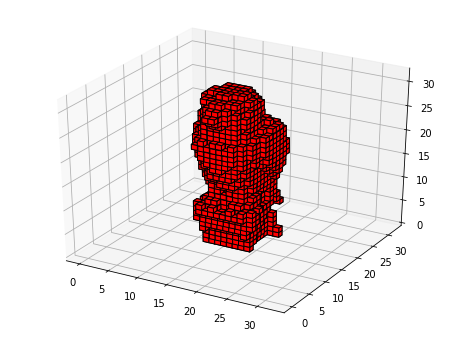

In [8]:
from data.thingi10k import Thingi10k
# get an stl example
thingi = Thingi10k.init10k()
stl_example = thingi.get_stl_path(stl_id=126660)
training_example = thingi.get_voxels(32, stl_file=stl_example)
plot_voxels(training_example)
training_example = np.reshape(training_example, (-1, 32, 32, 32, 1))

In [9]:
recon = vaegan.reconstruct(training_example)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  1.0
min:  0.0
mean:  0.007845193


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


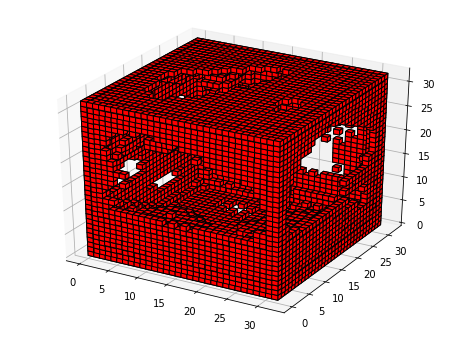

In [10]:
recon_threshold = recon > 0.00000000001
plot_voxels(recon_threshold)